In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
# from importlib import reload
# import vehicles
# import game
# import agents
# import evaluation
# import models
# reload(vehicles)
# reload(game)
# reload(agents)
# reload(evaluation)
# reload(models)
# import torch

In [3]:
from agents import BasicAttackerAgent, WolpertingerDefenderAgent
from evaluation import Evaluator
from game import GameConfig
from models import StateShapeData
from vehicles import JsonVehicleProvider, Vehicle, Vulnerability

vehicle_provider=JsonVehicleProvider("../subgame/python/solutions.json")
game_config=GameConfig(
    max_vehicles=30,
    cycle_every=3,
    cycle_num=5,
    cycle_allow_platoon=False
)

attacker=BasicAttackerAgent(1)
defender=WolpertingerDefenderAgent(
    state_shape_data=StateShapeData(
        num_vehicles=game_config.max_vehicles,
        num_vehicle_features=Vehicle.get_shape()[0],
        num_vulns=vehicle_provider.max_vulns,
        num_vuln_features=Vulnerability.get_shape()[0]
    )
)

engine = Evaluator(
    vehicle_provider=vehicle_provider,
    game_config=game_config,
    num_rounds=1000
)
engine.reset()

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
from training import WolpertingerDefenderAgentTrainer
trainer = WolpertingerDefenderAgentTrainer(
    batch_size=5,
)

In [5]:
stats_history = trainer.train(
    episodes=10,
    max_steps_per_episode=100,
    defender_agent=defender,
    attacker_agent=attacker,
    warmup=24,
    evaluator=engine,
)

RuntimeError: number of dims don't match in permute

In [157]:
trainer.optimize(engine.defender, trainer.memory)

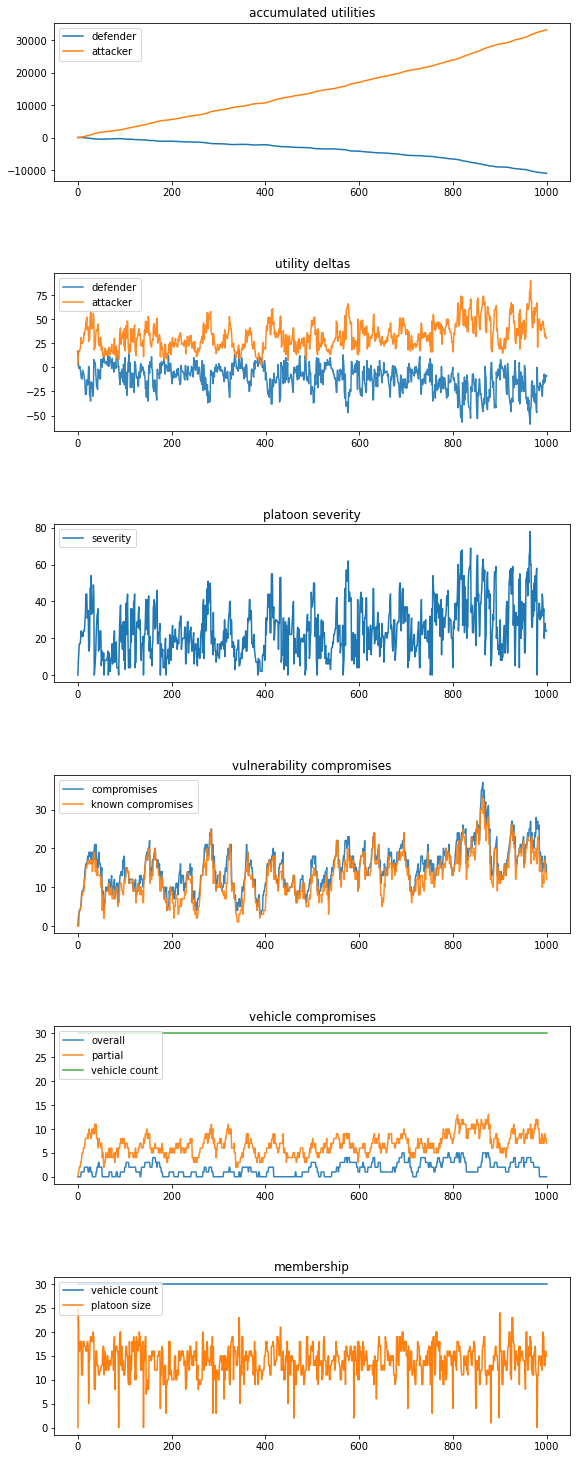

In [34]:
engine.plot(stats_history[0])

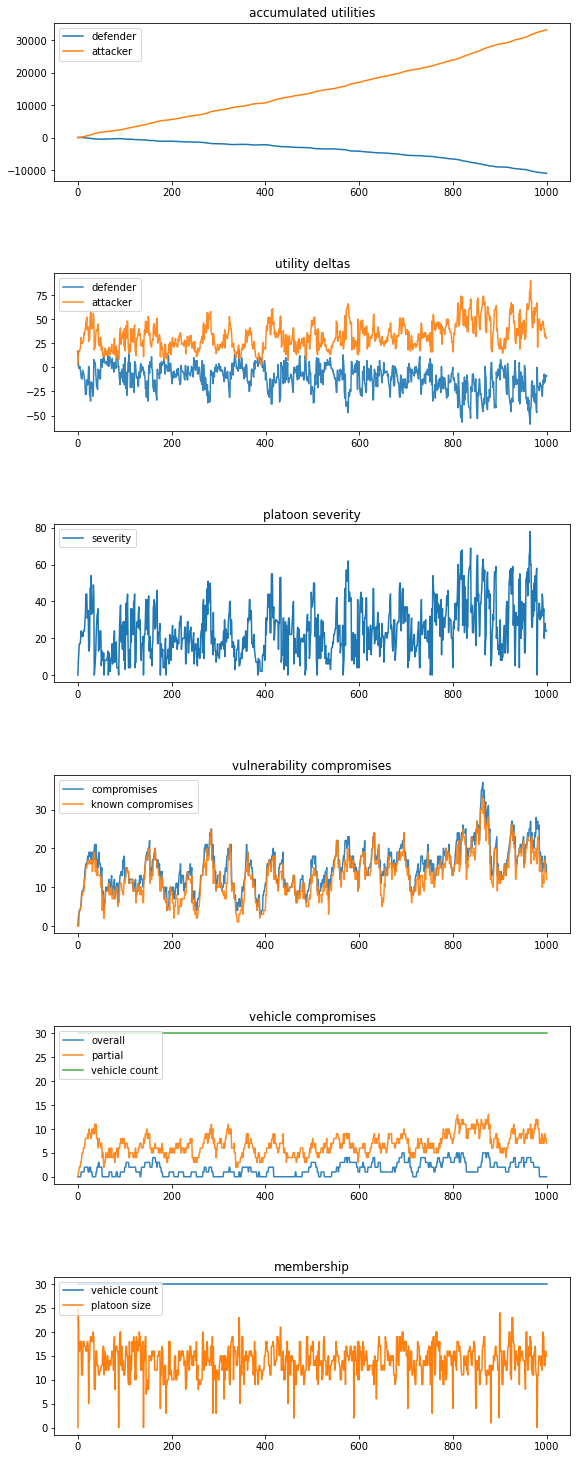

In [35]:
engine.plot(stats_history[-1])